BraTS Challenge Demo-Notebook

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from data_loading import BraTS_Dataset
from dataset_utils import split_cube, slice_cube, segment_entire_3d_cube
from dataset_utils import plot_batch, plot_minicube_pred_label, plot_cube_pred_label, plot_loss, animate_cube, plot_confusion_matrix
from data_loading import get_train_test_iters
torch.manual_seed(42)
from Architectures.unet_3d import UNet3D
from Architectures.unet_3d_context import UNet3D_Mini
from Architectures.unet_2d import UNet2D
from train import train_model
from custom_losses import get_loss, DiceLoss, FocalTverskyLoss

Data Loading

In [2]:
batch_size = 1
train_iter, test_iter = get_train_test_iters(os.path.join('..', 'Task01_BrainTumour', 'cropped'), batch_size=batch_size, shuffle=True, num_workers=0)

../Task01_BrainTumour/cropped/imagesTr
../Task01_BrainTumour/cropped/labelsTr
../Task01_BrainTumour/cropped/imagesTs
../Task01_BrainTumour/cropped/labelsTs


In [3]:
batch = split_cube(train_iter.next(), add_context=False)
batch['image'].shape

torch.Size([8, 4, 80, 96, 96])

Create the model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cpu


Training Loop

In [5]:
# hyperparameters
train_3d = True
add_context = False
compute_test_loss = True
epochs = 2
batches_per_epoch = 1
learning_rate = 0.1

# init model
if train_3d:
    if add_context:
        model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    model = UNet2D().to(device)

# init optimizer and loss_fn
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = DiceLoss()

print(f'training {model.__class__.__name__}:')
train_losses, test_losses = train_model(model, optim, loss_fn, epochs, device, train_3d, add_context,
                                        train_iter, test_iter, compute_test_loss, batches_per_epoch)

training UNet3D:
epoch 0: epoch_train_loss=0.753, epoch_test_loss=0.743
epoch 1: epoch_train_loss=0.745, epoch_test_loss=0.741


Plot losses

Loss curve using DiceLoss():


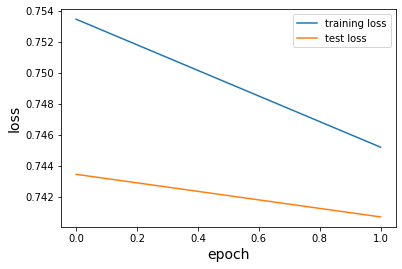

In [6]:
print(f'Loss curve using {loss_fn}:')
plot_loss(train_losses, test_losses)

Load inference model

In [7]:
weights_path = os.path.join('..','Weights')
weights_filename = os.listdir(weights_path)[len(os.listdir(weights_path))-1]
if train_3d:
    if add_context:
        inference_model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        inference_model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    inference_model = UNet2D().to(device)
#inference_model.load_state_dict(torch.load(os.path.join(weights_path, weights_filename)))
inference_model.eval();

Predict

<IPython.core.display.Javascript object>


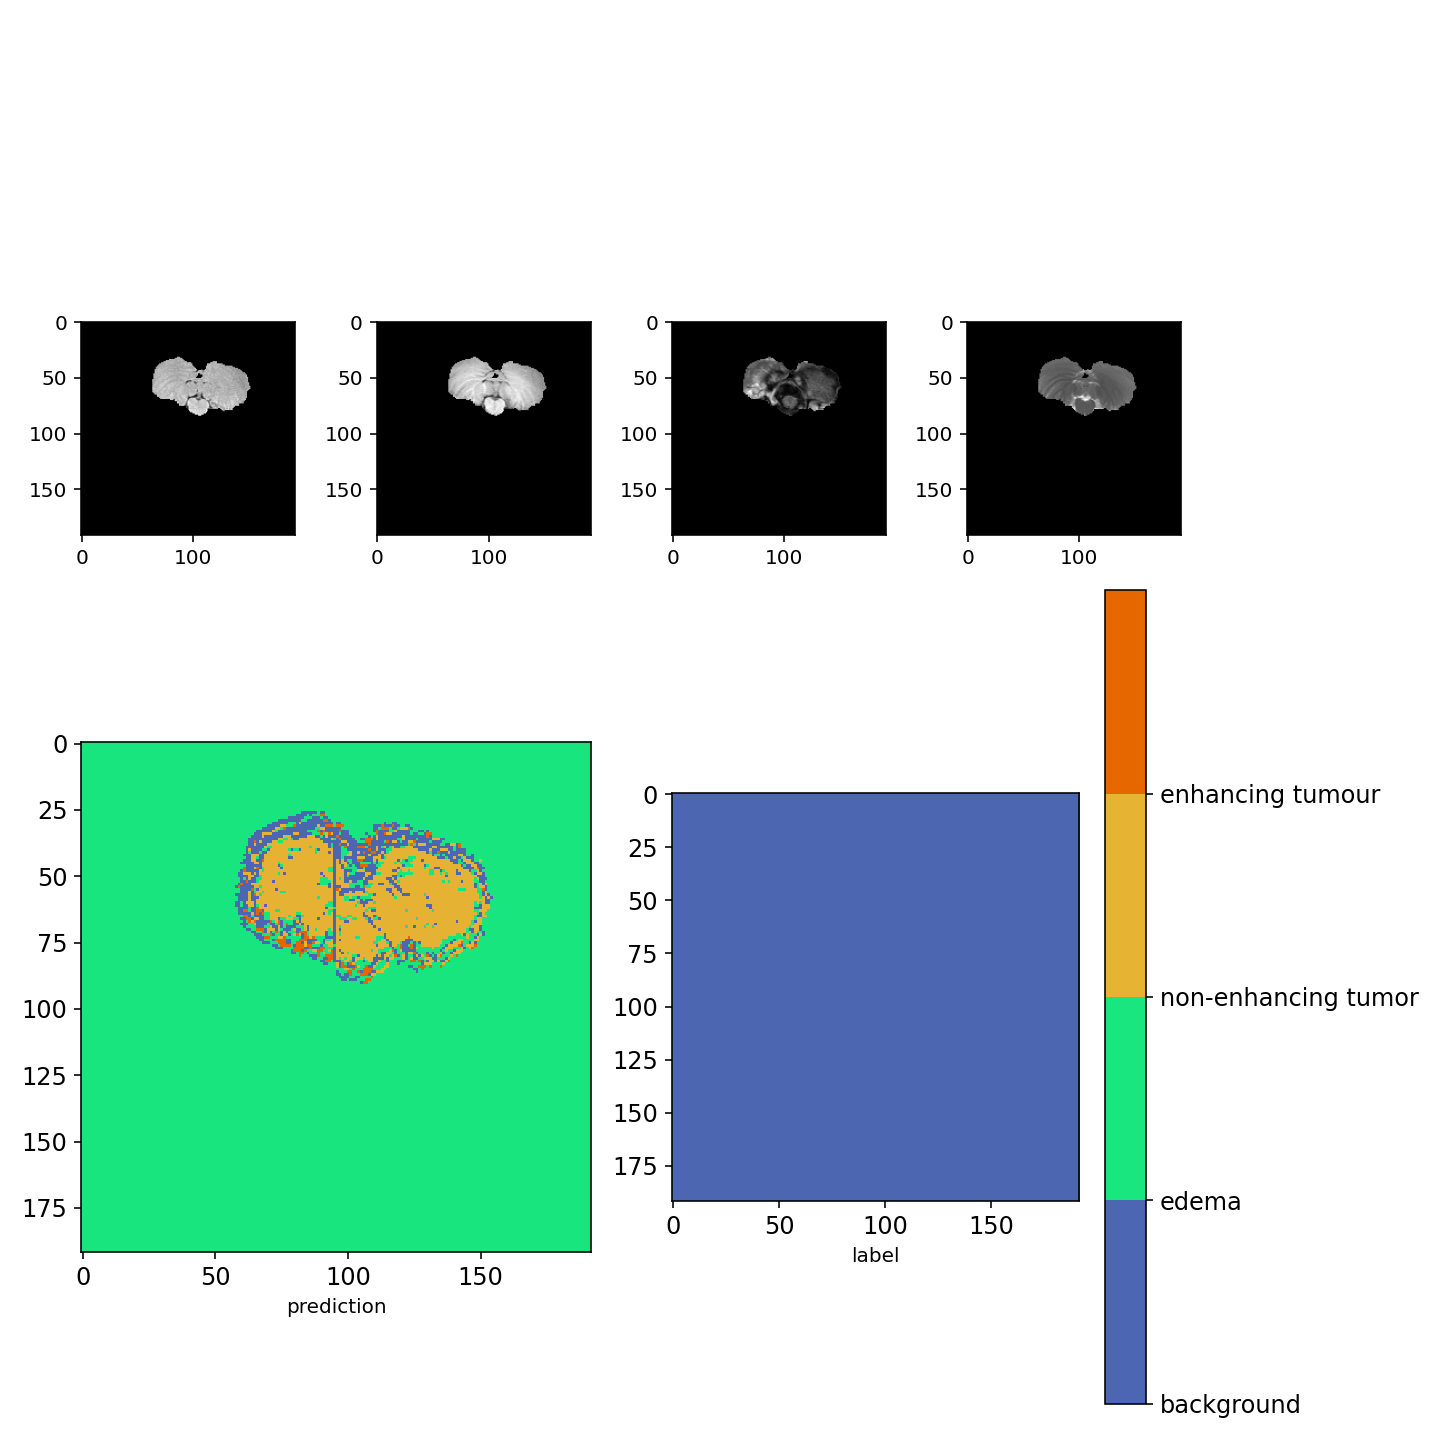

In [8]:
batch = train_iter.next()
%matplotlib notebook

ani = animate_cube(inference_model, batch, add_context, device, train_3d)
plt.show()

In [10]:
#path = os.path.join('..', 'Task01_BrainTumour', 'cropped')
#test_data = BraTS_Dataset(path, dataset_type='test')
#testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
#cf_matrix = plot_confusion_matrix(testloader, inference_model)
#cf_matrix.show()

train_iter, test_iter = get_train_test_iters(os.path.join('..', 'Task01_BrainTumour', 'cropped'), batch_size=batch_size, shuffle=False, num_workers=0)
cf_matrix = plot_confusion_matrix(test_iter, inference_model, train_3d, add_context, device)
cf_matrix.show()

../Task01_BrainTumour/cropped/imagesTr
../Task01_BrainTumour/cropped/labelsTr
../Task01_BrainTumour/cropped/imagesTs
../Task01_BrainTumour/cropped/labelsTs


ValueError: unknown is not supported